In [92]:
import numpy as np; import copy
def input_set(sys_no,input_type,input_len,scale): 
    if(0==input_type): 
        input_raw=np.random.standard_normal(input_len)
    elif(1==input_type): 
        input_raw=np.random.random(input_len)
    elif(2==input_type):
        input_raw=0.325*np.random.standard_normal(size=input_len);
    elif(3==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=(-0.1)*white_noise[0]
        input_raw[1]=0.04*input_raw[0]-0.1*white_noise[1]-0.01*white_noise[0]
        input_raw[2]=0.04*input_raw[1]-0.034*input_raw[0]-0.1*white_noise[2]-0.01*white_noise[1]-0.137*white_noise[0]
        input_raw[3]=0.04*input_raw[2]-0.034*input_raw[1]+0.0396*input_raw[0]-0.1*white_noise[3]-0.01*white_noise[2] \
                     -0.137*white_noise[1]+0.0353*white_noise[0]
        for t in range(4,input_len):
            input_raw[t]=0.04*input_raw[t-1]-0.034*input_raw[t-2]+0.0396*input_raw[t-3]-0.07656*input_raw[t-4] \
            -0.1*white_noise[t]-0.01*white_noise[t-1]-0.137*white_noise[t-2]+0.0353*white_noise[t-3]+0.06984*white_noise[t-4]
        input_raw=0.6*input_raw
    elif(4==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        for t in range(1,input_len):
            input_raw[t]=0.9*input_raw[t-1]#+0.1*white_noise[t] 
    elif(5==input_type):
        input_raw = np.zeros(input_len)
        white_noise = np.random.standard_normal(size=input_len)
        input_raw[0]=white_noise[0]
        input_raw[1]=1.79*input_raw[0]+white_noise[1]
        input_raw[2]=1.79*input_raw[1]-1.85*input_raw[0]+white_noise[2]
        input_raw[3]=1.79*input_raw[2]-1.85*input_raw[1]+1.27*input_raw[0]+white_noise[3]
        for t in range(4,input_len):
            input_raw[t]=1.79*input_raw[t-1]-1.85*input_raw[t-2]+1.27*input_raw[t-3]-0.41*input_raw[t-4] \
            +white_noise[t]
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    if(1==scale):
        input_raw_max=max(input_raw);input_raw_min=min(input_raw);
        for tt in range(0,input_len):
            input_raw[tt]=(0)+((input_raw[tt]-input_raw_min)*(0.5-0))/(input_raw_max-input_raw_min)
    output_raw=(np.zeros(input_len)) 
    if(1==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=(output_raw[i-1])/(1+output_raw[i-1]**2)+input_raw[i]**3
            #output_raw[i]=(1*output_raw[i-1])/(1+output_raw[i-1]**2)+ 1.3*input_raw[i]**2+ 1.0*input_raw[i-3]**2#0.5*(input_raw[i-3])
    elif(0==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=output_raw[i-1]/(1+output_raw[i-1]**2)+input_raw[i]**3
    elif(2==sys_no):
        for i in range(1,input_len): 
            output_raw[i]=input_raw[i]+0.5*np.exp(-((input_raw[i-1]-1)**2)/0.67)-0.5*np.exp(-((input_raw[i-1]+1)**2)/0.67) 
    snr=30;info_power=((np.linalg.norm(output_raw))**2)/input_len;snr_lin = 10**(snr/10);noise_power = info_power/snr_lin;
    output_noise = output_raw + np.sqrt(noise_power)*np.random.standard_normal(input_len)
    return input_raw,output_raw,output_noise
def PNIIR01_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+2;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_modul_sigm = np.zeros_like(output_modul);
    output_filter = np.zeros_like(input_data)
    dif_output_modul = np.zeros(M_num); 
    error = np.zeros_like(input_data)
    #for i in range(M_num+p_num-1,len(input_data)):
    for i in range(14+5+1,len(input_data)):
        feedback=np.zeros(M_num)
        for ii in range(M_num-1,-1,-1):  # external_input(r) and feedback(g)
            feedback[ii]=output_modul_sigm[0,i-ii-1]
            if(ii==(M_num-1)):
                external_input[ii]=output_modul_sigm[0,i-ii-2]
            else :
                external_input[ii]=output_modul_sigm[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            input_module[ii,p_num+1]= feedback[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_modul_sigm[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            dif_output_modul[ii]=( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/ \
            ( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        #if(0==i%100): 
            #print('output_modul:',output_modul[:,i])
            #print('dif_output_modul:',dif_output_modul)
        output_filter[i]=np.dot(weight_linear,output_modul_sigm[:,i].T) + sum(output_modul[:,i])      
        error[i]=desire_data[i-1] - output_filter[i]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]+input_module[0,:]*dif_output_modul[iiii]*weight_linear[iiii];
            weight_nonlin[iiii,:]+=train[0]*error[i]*input_module_pd1[iiii,:]
        weight_linear+=train[1]*error[i]*(output_modul_sigm[:,i]).T
    return output_filter,error,weight_linear,weight_nonlin
def PNIIR01_model_zhao(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+2;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_modul_sigm = np.zeros_like(output_modul);
    output_filter = np.zeros_like(input_data)
    dif_output_modul = 0; 
    error = np.zeros_like(input_data)
    #for i in range(M_num+p_num-1,len(input_data)):
    for i in range(14+5+1,len(input_data)):
        feedback=np.zeros(M_num)
        for ii in range(M_num-1,-1,-1):  # external_input(r) and feedback(g)
            feedback[ii]=output_modul_sigm[0,i-ii-1]
            if(ii==(M_num-1)):
                external_input[ii]=output_modul_sigm[0,i-ii-2]
            else :
                external_input[ii]=output_modul_sigm[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            input_module[ii,p_num+1]= feedback[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_modul_sigm[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/ \
            ( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_filter[i]=np.dot(weight_linear,output_modul_sigm[:,i].T) + sum(output_modul[:,i])      
        error[i]=desire_data[i-1] - output_filter[i]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]+dif_output_modul*weight_linear[iiii];
            weight_nonlin[iiii,:]=weight_nonlin[iiii,:]+train[0]*error[i]*input_module_pd1[iiii,:]
        weight_linear=weight_linear+train[1]*error[i]*(output_modul_sigm[:,i]).T
    return output_filter,error,weight_linear,weight_nonlin
def PNIIR02_model(input_data,desire_data,M_num,p_num,train):
    nonlin_input_len=p_num+2;
    weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
    weight_linear = np.zeros(M_num)
    input_module = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len);
    input_module_pd1 = np.zeros_like(input_module)
    external_input = np.zeros(M_num); 
    output_modul = np.zeros(M_num*(len(input_data))).reshape(M_num,len(input_data)); 
    output_modul_sigm = np.zeros_like(output_modul);
    output_filter = np.zeros_like(input_data)
    error = np.zeros_like(input_data)
    #for i in range(M_num+p_num-1,len(input_data)):
    for i in range(14+5+1,len(input_data)):
        feedback=np.zeros(M_num)
        for ii in range(M_num-1,-1,-1):  # external_input(r) and feedback(g)
            feedback[ii]=output_modul_sigm[ii,i-1]
            if(ii==(M_num-1)):
                external_input[ii]=output_modul_sigm[ii,i-2]
            else :
                external_input[ii]=output_modul_sigm[ii+1,i]
            for iii in range(0,p_num):
                input_module[ii,iii]=input_data[i-ii-iii-1] # p input
            input_module[ii,p_num]  = external_input[ii]
            input_module[ii,p_num+1]= feedback[ii]
            output_modul[ii,i]=np.dot(weight_nonlin[ii,:],input_module[ii,:].T)
            output_modul_sigm[ii,i]=1./(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))   
            dif_output_modul=input_module[ii,:]*( np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))) )/( (1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i]))))*(1+np.exp((-1)*(copy.deepcopy(output_modul[ii,i])))) )
        output_filter[i]=np.dot(weight_linear,output_modul_sigm[:,i].T) + sum(output_modul[:,i])      
        error[i]=desire_data[i-1] - output_filter[i]
        for iiii in range(0,M_num):
            input_module_pd1[iiii,:]=input_module[iiii,:]+dif_output_modul*weight_linear[iiii];
            weight_nonlin[iiii,:]=weight_nonlin[iiii,:]+train[0]*error[i]*input_module_pd1[iiii,:]
        weight_linear=weight_linear+train[1]*error[i]*(output_modul_sigm[:,i]).T
    return output_filter,error,weight_linear,weight_nonlin

In [38]:
import numpy as np
M_num=5;nonlin_input_len=3+2;
weight_nonlin = np.zeros(M_num*nonlin_input_len).reshape(M_num,nonlin_input_len)
(np.dot(weight_nonlin[0,:],weight_nonlin[0,:].T))

0.0

In [55]:
weight_lin,weght_non

(array([0.03200025, 0.02936532, 0.02874904, 0.0286088 , 0.02852621]),
 array([[0.13250491, 0.06450589, 0.03405112, 0.02355778, 0.02273491],
        [0.06508272, 0.03431224, 0.02399281, 0.02306712, 0.02090775],
        [0.03489082, 0.02425447, 0.01566421, 0.02295561, 0.01964888],
        [0.02483375, 0.01592608, 0.01749317, 0.0228897 , 0.01863165],
        [0.01650379, 0.0177543 , 0.0175005 , 0.0170167 , 0.01785015]]))

apoch: 0 PNIIR(1) -35.94910774870455 dB PNIIR(2) -35.94910350451406 dB
apoch: 1 
 mean_MSE: PNIIR(1) 0.0002819504235943577 -35.49827248603367 dB 
 PNIIR(2) 0.00028195071900056194 -35.49826793582887 dB


C:\Users\Administrator\AppData\Local\Temp/ipykernel_15932/689077990.py:20: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNIIR01),color='red',label="PNIIR(1)",linewidth=0.6)
C:\Users\Administrator\AppData\Local\Temp/ipykernel_15932/689077990.py:21: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.arange(N),10*np.log10(error2_sum_PNIIR02),color='blue',label="PNIIR(1)",linewidth=0.6)


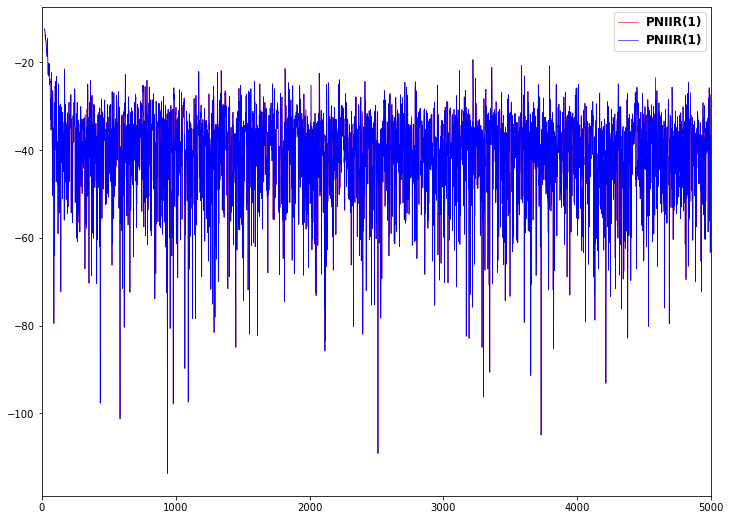

In [94]:
N = 5000; M=5; p=3; apoch=1
train_para=np.array([0.008,0.01]) 
error2_sum_PNIIR01=np.zeros(N);
error2_sum_PNIIR02=np.zeros(N);
for times in range(0,apoch): 
    x_raw,d_raw,d_noise=input_set(1,0,N,1)    #  gaussian
    #x_raw,d_raw,d_noise=input_set(1,1,N,0)    #  gaussian
    output_filter,error_PNIIR01,weight_lin,weght_non=PNIIR01_model(x_raw,d_raw,M,p,train_para)  #PNIIR01
    output_filter,error_PNIIR02,weight_lin,weght_non=PNIIR01_model_zhao(x_raw,d_raw,M,p,train_para)  #PNIIR02
    error2_sum_PNIIR01+=error_PNIIR01**2
    error2_sum_PNIIR02+=error_PNIIR02**2
    if(0==times%10):
        print('apoch:',times,'PNIIR(1)',10*np.log10(np.mean(error_PNIIR01[-100:]**2)),'dB',\
              'PNIIR(2)',10*np.log10(np.mean(error_PNIIR02[-100:]**2)),'dB')
error2_sum_PNIIR01/=apoch;
error2_sum_PNIIR02/=apoch;
print('apoch:',apoch,'\n','mean_MSE:','PNIIR(1)',np.mean(error2_sum_PNIIR01[-106:-6]),10*np.log10(np.mean(error2_sum_PNIIR01[-106:-6])),'dB',\
      '\n','PNIIR(2)',np.mean(error2_sum_PNIIR02[-106:-6]),10*np.log10(np.mean(error2_sum_PNIIR02[-106:-6])),'dB')
import matplotlib.pyplot as plt; plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N),10*np.log10(error2_sum_PNIIR01),color='red',label="PNIIR(1)",linewidth=0.6)
plt.plot(np.arange(N),10*np.log10(error2_sum_PNIIR02),color='blue',label="PNIIR(1)",linewidth=0.6)
plt.xlim(0,N)
plt.legend(loc=0,numpoints=1);leg=plt.gca().get_legend();ltext=leg.get_texts()
plt.setp(ltext,fontsize=12,fontweight='bold');plt.show()

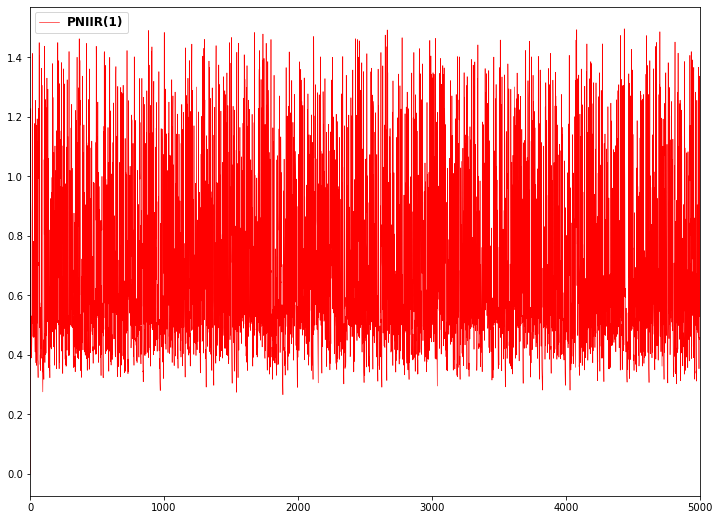

In [59]:
x_raw,d_raw,d_noise=input_set(1,1,N,0)    #  gaussian
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9)); 
plt.plot(np.arange(N), d_raw, color='red',label="PNIIR(1)", linewidth=0.6)
plt.xlim(0,N)
plt.legend(loc=0, numpoints=1);leg = plt.gca().get_legend();ltext = leg.get_texts()
plt.setp(ltext, fontsize=12, fontweight='bold');plt.show()

In [6]:
np.mean(d_raw)  
    #0.2703

0.25547400305102014